In [43]:
%matplotlib inline

import pandas as pd

from collections import Counter
from functools import reduce

In [2]:
df = pd.read_csv('data/bc.data', names=[
    'age',
    'menopause',
    'tumor-size',
    'inv-nodes',
    'node-caps',
    'deg-malig',
    'breast',
    'breast-quad',
    'irradiat',
    'class'
])

df

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events
5,50-59,premeno,25-29,3-5,no,2,right,left_up,yes,no-recurrence-events
6,50-59,ge40,40-44,0-2,no,3,left,left_up,no,no-recurrence-events
7,40-49,premeno,10-14,0-2,no,2,left,left_up,no,no-recurrence-events
8,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events
9,40-49,ge40,40-44,15-17,yes,2,right,left_up,yes,no-recurrence-events


In [3]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


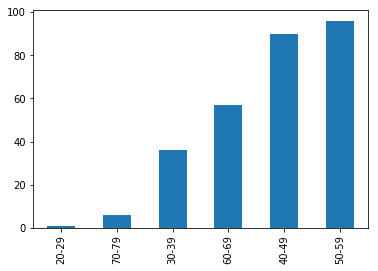

In [13]:
df.age.value_counts().sort_values().plot(kind='bar')

In [59]:
# interval_string is a string with the format 'a-b', e.g. '50-59'
def get_interval_mean(interval_string):
    a, b = list(map(float, interval_string.split('-')))
    return (a + b) / 2

def get_binned_mean(series):
    counts = series.value_counts().to_dict().items()
    sum = reduce(lambda acc, x: acc + get_interval_mean(x[0]) * x[1], counts, 0)
    return sum / series.size

In [60]:
get_binned_mean(df.age)

51.14335664335665

In [70]:
get_binned_mean(df['tumor-size'])

26.405594405594407

In [33]:
def get_median_index(size):
    return size / 2 if size % 2 == 0 else (size + 1) / 2

median_index = int(df.age.size / 2)
median_index

143

In [34]:
# df.age.sort_values().iloc[median_index]

size = 5
0, 1, 2, 3, 4 -> 2
0, 1, 2, 3 -> 1 + 2 / 2